## Rationale

Experiment with approaches to monitor resource utlization of a process during simulation. Validate two approaches as follows:
1. Monkey-patching to decorate some methods of the resource class to inject logging behavior.
2. Run a monitoring process to poll a resource at some recurring frequency for stats.

In [83]:
# Preliminaries
from dietician_monitor import G, Patient, Consultation, patch_resource, get_monitor
from plotnine import *

Note that import caches classes (and variables, functions) defined in the imported package. This has two consequences:
1. Changes to the code-base of imported module will not reflect in the Jupyter notebook simply by re-running the import statement. Either restart the Jupyter notebook's kernel or explicitly reload.
2. The class G has attributes that are class-level. These include arrays that have items appended to them during a simulation run. These arrays will accumulate history *across* simulation runs unless cleared between runs. Remember, initialization of class-level attributes happens only once, during import. Unlike object-level attributes that are initialized via constructor call each time an object is instantiated. Provide a class-level method to clear accumulators and employ this method before each independent simulation run. 

### I. Monkey-Patch Monitor

Use the ```monitor_resource()``` method of class Consultation and pass the `dietician` as the name of the resource to monitor. Note that this method accepts a list of resource names but we have only one resource (i.e. deitician) in the model so we pass a list of one. The method gets the callback from ```get_monitor()``` function in the module 'dietician_monitor' and patches each named resource (here, dietician) using ```patch_resource()``` function from the same module.

Patching means that the get/put or request/release methods of the target resource are decorated to execute the callback before or after according to how the callback is passed. Use argument ```pre=``` to pass a callback that is executed before any of these resource methods and ```post=``` to pass a callback for execution afterwards. We have passed the callback to execute afterwards.

In [84]:
c = Consultation()
G.simulation_horizon = 30
c.monitor_resource()
res = c.run_once()

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 1 exited at 6.01, having spent 6.01 in clinic.
Patient 2 entered the queue at 6.32
Patient 2 entered consultation at 6.32, having waited 0.00
Patient 2 exited at 10.62, having spent 4.30 in clinic.
Patient 3 entered the queue at 13.64
Patient 3 entered consultation at 13.64, having waited 0.00
Patient 3 exited at 15.67, having spent 2.03 in clinic.
Patient 4 entered the queue at 21.57
Patient 4 entered consultation at 21.57, having waited 0.00
Patient 5 entered the queue at 22.83
Patient 6 entered the queue at 25.39
Patient 7 entered the queue at 27.08
Patient 8 entered the queue at 29.36


Now obtain the results of the lone simulation run from class G. The attribute ```resource_monitor``` has tuples with the timestamp, the resource capacity employed and the resource capacity awaited. Compare the simulated trajectory from printed output with the contents of ```G.resource_monitor```. The first patient sees the dietician immediately, so the timestamp 0 has count 1 and awaited 0. 

In [85]:
# Plot
print(G.resource_monitor)
print(G.arrived)
#x_dietcian, y_dietician = list(zip(*G.resource_monitor["dietician"]))

{'dietician': [(0, 1, 0), (6.008246457265839, 0, 0), (6.324194256773248, 1, 0), (10.623524720375622, 0, 0), (13.640286972371683, 1, 0), (15.671116916216425, 0, 0), (21.566590771253246, 1, 0), (22.829255737928065, 1, 1), (25.385430134246295, 1, 2), (27.08086033902954, 1, 3), (29.358275402486395, 1, 4)]}
[0, 6.324194256773248, 13.640286972371683, 21.566590771253246, 22.829255737928065, 25.385430134246295, 27.08086033902954, 29.358275402486395]


Thence, observe the following with each event:
1. A patient enters the queue and the capacity awaited is incremented by 1.
2. A patient enters consultation and the capacity employed is incremented by 1.
3. A patient exits after consultation, the capacity employed decreases by 1. 

When a patient is in queue waiting for consultation, then they should see the dietician as soon as available. One consultation begins as soon as the other ends. **HOWEVER** we note that this is reflected in the printed output but not in the monitor from monkey-patched resource methods. 

## Why?

Because monkey-patching has decorated the target resource's get/put or request/release methods. This misses the scenario when capacity released by one entity is immediately seized by the entity next-in-line. A resource has no method for capacity allocated, only capacity requested or released. Therefore, when resource capacity is requested, one of two log-events can occur: (1.) the entity is queued, in which case the capacity awaited is incremented by 1 (2.) the entity is served, in which case the capacity employed is incremented by 1. Capacity allocated after a delay is not tracked.

## Unfortunately, this corrupts the data collected to describe resource utilization.

**FIXED!** Added function 'help_monitor' to address the reporting gap. 

Let us see how the alternative approach fares.

## II. Monitor via Parallel Polling Process

This approach launches a process with the sole purpose of gathering data in the shared environment with the main process. Run the ```monitor_resource()``` method of class Consultation with ```proc_monitor=True```. Data are collected at regular time intervals. Contrast this with data collection when events occur in the monkey-patch approach. The data are gathered at finer resolution than the simulation step, e.g. 0.25 of a simulation time-step. (Think of Nyquist theorem.) 

In [86]:
c = Consultation()
G.simulation_horizon = 12
c.monitor_resource()
res = c.run_once(proc_monitor=True)

Patient 1 entered the queue at 0.00
Patient 1 entered consultation at 0.00, having waited 0.00
Patient 1 exited at 1.83, having spent 1.83 in clinic.
Patient 2 entered the queue at 6.39
Patient 2 entered consultation at 6.39, having waited 0.00
Patient 3 entered the queue at 10.20
Patient 4 entered the queue at 10.83


In [87]:
print(G.resource_monitor)
print(G.resource_utilization)

{'dietician': [(0, 1, 0), (1.8260619702336593, 0, 0), (6.389113762961665, 1, 0), (10.202065756263101, 1, 1), (10.832515391690167, 1, 2)]}
{'dietician': [(0, 0, 0), (0.25, 1, 0), (0.5, 1, 0), (0.75, 1, 0), (1.0, 1, 0), (1.25, 1, 0), (1.5, 1, 0), (1.75, 1, 0), (2.0, 0, 0), (2.25, 0, 0), (2.5, 0, 0), (2.75, 0, 0), (3.0, 0, 0), (3.25, 0, 0), (3.5, 0, 0), (3.75, 0, 0), (4.0, 0, 0), (4.25, 0, 0), (4.5, 0, 0), (4.75, 0, 0), (5.0, 0, 0), (5.25, 0, 0), (5.5, 0, 0), (5.75, 0, 0), (6.0, 0, 0), (6.25, 0, 0), (6.5, 1, 0), (6.75, 1, 0), (7.0, 1, 0), (7.25, 1, 0), (7.5, 1, 0), (7.75, 1, 0), (8.0, 1, 0), (8.25, 1, 0), (8.5, 1, 0), (8.75, 1, 0), (9.0, 1, 0), (9.25, 1, 0), (9.5, 1, 0), (9.75, 1, 0), (10.0, 1, 0), (10.25, 1, 1), (10.5, 1, 1), (10.75, 1, 1), (11.0, 1, 2), (11.25, 1, 2), (11.5, 1, 2), (11.75, 1, 2)]}


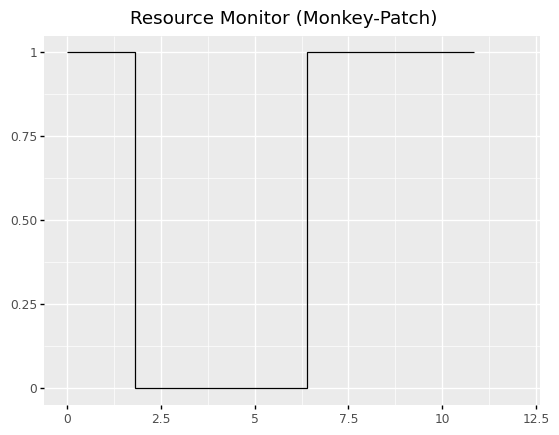

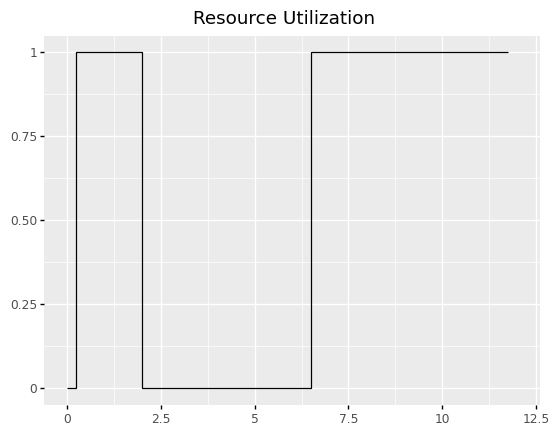

<ggplot: (323968293)>

In [88]:
x_monkey, y_monkey, _ = list(zip(*G.resource_monitor["dietician"]))
x_monitr, y_monitr, _ = list(zip(*G.resource_utilization['dietician']))

pMonkey = ggplot(aes(x=x_monkey, y=y_monkey)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Monitor (Monkey-Patch)")
ggplot.draw(pMonkey)
pMonitr = ggplot(aes(x=x_monitr, y=y_monitr)) \
            + geom_step() \
            + xlim(0, G.simulation_horizon) \
            + ggtitle("Resource Utilization")
pMonitr

Let's generate a utilization metric as Area Under Curve AUC). Use ```trapz()``` from ```numpy``` for numerical integration. This works for numerical integration of a function sampled at regular intervals and appears problematic with irregular interavals. Hence, prefer polling over  monkey-patching here. The latter will require hand-coding the numerical integration. 

In [92]:
from numpy import trapz
avaUtil = G.number_of_dieticians * x_monitr[-1]
netUtil = trapz(y_monitr, x_monitr) 
percUtil = netUtil / avaUtil * 100
print("Dietician reported percentage utilization of {}/{} = {:.2f}".format(netUtil, avaUtil, percUtil))

Dietician reported percentage utilization of 7.125/11.75 = 60.64


## CONCLUSION

We have tested two approaches to monitor process during simulation and track resource utilization. The monkey-patching approach decorates some methods of a resource (get/put or request/release) to inject logging behavior before/after. The method is elegant. Use with caution for the following reasons:
1. Code is relatively complex but flexible.
2. Logging is event-driven, i.e. as an when a get/put or request/release method is called.
3. Does not record capacity allocated after delay, only capacity requested, potentially corrupting logs.

The alternative is a process in shared environment with the main process. This polls the target resource for stats that are accumulated in an array. Caveat is that polling in less efficient.

*RECOMMENDATION* We've fixed the issue with monkey-patching by adding a helper function. The code now has three functions that work together for monkey-patching as follows:
1. ```patch_resource()```: Implements the decorator pattern to inject logging before/after calls to get/put or request/release methods of resource class.
2. ```get_monitor()```: Returns the callback that is passed as argument ```pre=``` or ```post=``` of ```patch_resource()```.
3. ```help_monitor()```: Updates the data-structure (dictionary of lists) that stores data from monitoring process when capacity requested is allocated after a delay. 

These functions are independent of the process being modeled. The class ```Consultation``` uses these functions for monkey-patching as follows:
1. Method ```monitor_resource()``` obtains a callback instance for each resource with ```get_monitor()``` and monkey-patches it with ```patch_resource()```. 
2. Calls ```help_monitor()``` after a request is fullfilled.

Note that the class ```G``` must have attributes set up for monitoring that ```Consultation``` can stream payloads to.

## EXTRA

Some exploratory commands. Ignore.

In [91]:
import simpy
env = simpy.Environment
res = simpy.Resource(env=env, capacity=1)
print(type(res))
type(res) == 'simpy.resources.resource.Resource'
isinstance(res, simpy.resources.resource.Resource)

<class 'simpy.resources.resource.Resource'>


True